<a href="https://colab.research.google.com/github/pankaj-hash/SimilarityofDocuments/blob/main/LocalitySensitiveHashing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Locality Sensitive Hashing

This notebook is a tutorial and python implementation of locality sensitive hashing.

We demonstrate the tools using a very very small dataset, consisting of 4 articles pulled from CNN, and a 5th that is a partial concatenation of 3 of those, to artificialy produce some high similarity scores.

Since this is a small dataset, we can easily compare our approximations to the true similarity scores amongst text files. We do so throughout. The layout of this notebook is as follows:

Part I: computing similarity amongst text documents
1. Introduce a shingle function. Clean and split each text file into a set of K-shingles
2. Compute the exact Jaccard similarity (intersection over union) between all pairs
3. Create and apply a MinHashing class:
    1. Initialize with a dictionary of key-value pairs for the shingles
    2. Apply "universal hashing" to perform minhashing on a shingle set
    3. can be called like a function to compute a **signature matrix**
4. Evaluate MinHashing effectiveness by computing scores of all pairs
5. Introduce LSH for finding **candidate pairs**, i.e. use a banded signature matrix to find all pairs whose similarity is likely above a threshold
6. Make this efficient, by using hash table for band, column ids, allowing O(n) comparison

Part II: computing similarity amongst vectors

* Afterwards, we provide an additional LSH family for Euclidean spaces, namely cosine similarity. 
* This is used to ascertain the similarity of vectors in a D-dimensional space.
* Can be implemented using the *Random Hyperplanes* hashing method.

In [ ]:
import os
import time
import itertools
import collections
import numpy as np
import matplotlib.pyplot as plt

# Part I: document similarity

## MinHashing without Locality Sensitive Hashing

### Shingling

We illustrate how to convert a word document into a list of shingles.
We will use three similar strings, and see how this shows similarity.
I made a directory and copied 4 files from CNN, then the 5th is a concatenation of 3 of them, randomly deleting some lines

In [2]:
import os
HOME = os.getcwd()
TARGET = os.path.join(HOME, 'sampledocs/')

documents = []
for article in os.listdir(TARGET):
    if article == 'stopwords':
        continue
    path = os.path.join(TARGET, article)
    with open(path, 'r') as file:
        documents.append(file.read())
        
stopwords = []
with open(os.path.join(TARGET, 'stopwords'), 'r') as file:
    for line in file:
        stopwords.append(line.strip())
        
for i, doc in enumerate(documents):
    doc = doc.strip().replace('\n', ' ').lower()
    for word in stopwords:
        doc = doc.replace(' '+word+' ', ' ')
    documents[i] = doc

print(f"Average char-length: \
{np.mean(np.array([len(x) for x in documents]))}")
print(f"Min char-length: {min(len(x) for x in documents)}")
print(f"Max char-length: {max(len(x) for x in documents)}")

Average char-length: 3651.6
Min char-length: 2412
Max char-length: 5873


In [3]:
# create K-shingles by sliding window approach
def getShingles(str1, K=5):
    d1 = set()
    for i in range(len(str1)-K):
        d1.add(str1[i:i+K])
    print(f"Found {len(d1)} unique shingles, out of {len(str1)} possible.")
    return d1
doc_shingles = [getShingles(s, 5) for s in documents]

Found 3953 unique shingles, out of 5873 possible.
Found 2782 unique shingles, out of 3673 possible.
Found 2060 unique shingles, out of 3009 possible.
Found 1918 unique shingles, out of 2412 possible.
Found 2091 unique shingles, out of 3291 possible.


### Define the Jaccard similarity (intersection over union)

In [4]:
def jaccardSim(d1,d2):
    return len(d1.intersection(d2))/len(d1.union(d2))

# itertools.combinations finds all (,n) n-pairs
# then we use a map op on the tuples with jaccardSim
pairs = itertools.combinations(documents, 2)
pair_labels = []
pair_sims = []
for x1, x2 in itertools.combinations(zip(range(len(doc_shingles)),doc_shingles), 2):
    pair_labels.append((x1[0],x2[0]))
    pair_sims.append(jaccardSim(x1[1],x2[1]))
    
print(f"**~~~~~~ True similarity scores ~~~~~~**")
print("Pair\tScore")
print("-"*14)
for pair, score in zip(pair_labels, pair_sims):
    print(f"{pair}\t{score:.3f}")

**~~~~~~ True similarity scores ~~~~~~**
Pair	Score
--------------
(0, 1)	0.083
(0, 2)	0.336
(0, 3)	0.400
(0, 4)	0.294
(1, 2)	0.069
(1, 3)	0.052
(1, 4)	0.081
(2, 3)	0.050
(2, 4)	0.093
(3, 4)	0.051


In [5]:
# Take union of all sets. Convert to an array and assign
# each element an integer based on position in array
fullset = set.union(*doc_shingles)
shingle_dict = dict(zip(list(fullset),range(len(fullset))))
print(f"There are {len(shingle_dict)} shingles")

There are 7534 shingles


In [13]:
shingle_dict

{'satio': 0,
 'n, ad': 1,
 'intme': 2,
 'isput': 3,
 'cnn t': 4,
 ' hoar': 5,
 's pri': 6,
 'ight.': 7,
 ' summ': 8,
 'fizer': 9,
 'y ame': 10,
 ' unan': 11,
 '70s s': 12,
 'ical ': 13,
 'oward': 14,
 'g peo': 15,
 's loa': 16,
 'urt s': 17,
 'tant ': 18,
 'cultu': 19,
 'aid i': 20,
 'd the': 21,
 'res o': 22,
 'trump': 23,
 'ans u': 24,
 "i's w": 25,
 'ratit': 26,
 ' meek': 27,
 'ly ac': 28,
 'speci': 29,
 'g hot': 30,
 'ump l': 31,
 'ahn s': 32,
 'op pl': 33,
 't los': 34,
 'ed lo': 35,
 'feroc': 36,
 'g sai': 37,
 'deser': 38,
 'loyee': 39,
 'itiou': 40,
 'ince ': 41,
 ' (so ': 42,
 'ied b': 43,
 'y sho': 44,
 'res d': 45,
 'gue r': 46,
 'toric': 47,
 'medie': 48,
 'tting': 49,
 'ather': 50,
 '" "ri': 51,
 'n las': 52,
 'new d': 53,
 'p ven': 54,
 'ttle ': 55,
 'ump d': 56,
 'quara': 57,
 'tors ': 58,
 '. add': 59,
 'ct jo': 60,
 'nd va': 61,
 'ews r': 62,
 'ed al': 63,
 'ce va': 64,
 'on de': 65,
 's two': 66,
 'esper': 67,
 't con': 68,
 'es ov': 69,
 'nts n': 70,
 'ards ': 71,
 '

### 3. Define the MinHash class, capable of creating a signature matrix

Note: this only takes sets as input (not matrices) allowing us to efficiently deal with sparse matrices

In [8]:
# Create a hash function
# define as a callable class, so that we only
# intialize random functions once
class HashManager():
    def __init__(self, shingle_dict):
        self.shingle_dict = shingle_dict
        self.N = len(shingle_dict)
        self.params = None
        
    def _initParams(self, n_sig):
        self.params = np.random.randint(self.N, size=[n_sig,2])
    
    def _permuteRow(self, row):
        return (self.params@np.array([1,row]))%self.N
    
    def __call__(self, docs, n_sig, init=True):
        # Initialize if we change signature matrix length
        # or if we request to re-initialize
        if self.params is None or len(self.params) != n_sig or init:
            self._initParams(n_sig)
            
        #initialize signature matrix
        sig = np.full((n_sig, len(docs)), np.inf)
        
        # each doc in docs is assumed to be an iterable object
        for j, doc in enumerate(docs):
            for shingle in doc:
                orig_row = shingle_dict[shingle]
                curr_col = self._permuteRow(orig_row)
                sig[:,j] = np.minimum(sig[:,j],curr_col)
        return sig.astype(int)
    
# run some tests:
try:
    print("Initialization test: ", end="")
    hm = HashManager(shingle_dict)
    print("passed")

    print("Set parameters to right size: ", end="")
    hm._initParams(n_sig=4)
    assert(hm.params.shape == (4,2))
    print("passed")

    print("Permuting a row integer returns array: ", end="")
    curr_col = hm._permuteRow(3)
    assert(curr_col.shape == (4,))
    print("passed")

    print("Compute minhashed signature matrix: ", end="")
    hm(doc_shingles, 4)
    print("passed")
except Exception as e:
    print("failure")
    print(e.args)

Initialization test: passed
Set parameters to right size: passed
Permuting a row integer returns array: passed
Compute minhashed signature matrix: passed


In [15]:
hm = HashManager(shingle_dict)

### 4. Use MinHashing to compute similarity scores, and see how well it does

In [10]:
def trueSimScores(doc_shingles):
    pair_labels = []
    pair_sims = []
    idxs = range(len(doc_shingles))
    for x1, x2 in itertools.combinations(zip(idxs,doc_shingles), 2):
        pair_labels.append((x1[0], x2[0]))
        pair_sims.append(jaccardSim(x1[1], x2[1]))
    return dict(zip(pair_labels, pair_sims))
    
def sigSimScores(sig_mat):
#     cols = [sig_mat[:,i] for i in range(sig_mat.shape[1])]
    cols = sig_mat.T
    idxs = range(sig_mat.shape[1])
    
    pair_labels = []
    pair_sims = []
    for (i,col1), (j,col2) in itertools.combinations(zip(idxs, cols),2):
        pair_labels.append((i,j))
        pair_sims.append(np.mean(col1==col2))
    
    return dict(zip(pair_labels, pair_sims))

def printScoreComparison(true_dict, approx_dict):
    print(f"**~~~~~~ Similarity score comparison ~~~~~~**")
    print("Pair\t\tApprox\t\tTrue\t\t%Error")
    for pair, true_value in true_dict.items():
        approx_value = approx_dict[pair]
        err = 100*abs(true_value-approx_value)/true_value
        print(f"{pair}\t\t{approx_value:.3f}\t\t{true_value:.3f}\t\t{err:.2f}")

def candidatePairs(score_dict, threshold):
    return set(pair for pair, scr in score_dict.items() if scr>=threshold)

def accMatrix(true_dict, approx_dict, threshold):
    true_pairs = candidatePairs(true_dict, threshold)
    approx_pairs = candidatePairs(approx_dict, threshold)
    false_negatives = len(true_pairs - approx_pairs)
    false_positives = len(approx_pairs - true_pairs)
    print(f"False negatives: {false_negatives}")
    print(f"Potential false positives: {false_positives}")

sig_mat = hm(doc_shingles, 10)
true_score_dict = trueSimScores(doc_shingles)
approx_score_dict = sigSimScores(sig_mat)
printScoreComparison(true_score_dict, approx_score_dict)

print("True pairs:",candidatePairs(true_score_dict, 0.25))
print("Candidate pairs:",candidatePairs(approx_score_dict, 0.25))
accMatrix(true_score_dict, approx_score_dict, 0.4)

# print(f"**~~~~~~ Approximate similarity scores ~~~~~~**")
# print("Pair\t\tApproximate Score\t\tTrue Score")
# print("-"*14)
# for pair, score in sigSimScores(sig_mat):
#     print(f"{pair}\t{score:.3f}")
    
# print(f"**~~~~~~ True similarity scores ~~~~~~**")
# print("Pair\tScore")
# print("-"*14)
# for pair, score in zip(pair_labels, pair_sims):
#     print(f"{pair}\t{score:.3f}")

**~~~~~~ Similarity score comparison ~~~~~~**
Pair		Approx		True		%Error
(0, 1)		0.300		0.083		261.57
(0, 2)		0.200		0.336		40.52
(0, 3)		0.500		0.400		24.94
(0, 4)		0.400		0.294		35.83
(1, 2)		0.100		0.069		45.19
(1, 3)		0.100		0.052		93.46
(1, 4)		0.200		0.081		147.01
(2, 3)		0.100		0.050		100.48
(2, 4)		0.100		0.093		7.26
(3, 4)		0.000		0.051		100.00
True pairs: {(0, 3), (0, 2), (0, 4)}
Candidate pairs: {(0, 1), (0, 3), (0, 4)}
False negatives: 0
Potential false positives: 1


## Adding Locality Sensitive Hashing: preliminary band-structure theory, how to choose band size

### Effects of changing b,r at fixed n

Now implement Locality-sensitive hashing. We use a band structure on the signature matrix. If the matrix has $n$ rows, then we divide it into $b$ bands each of width $r$, such that
$$n = b*r$$

Let $p$ be the true similarity score (match percent) between a pair. The probability of matching every integer in a band is

$$\text{prob. one band doesn't match } = 1-p^r$$

Now the probability that NONE of the $b$ bands match is given by

$$\text{prob. no bands match } = (1-p^r)^b$$

Therefore, the probability that at least one band matches, is

$$P(\geq 1\text{ match}) = 1-(1-p^r)^b$$

Now, we want this to be our criteria for a candidate pair. That is, two signatures columns are a candidate pair if $P \geq 1/2$. We will see in the plot below, that as the signature matrix increases, we can tune $r$ and $b$ to approximately be a step function around the true value of $p$. The goal is to find as few candidate pairs as possible, while also making sure we find them all.

Draw a vertical line at the true p value
The area UNDER the curve $P(x<p)$ represents the rate of potential false positives

the area ABOVE the curce $P(x\geq p)$ represents the rate of false negatives

For various values of $r$, $b$, we plot the result below


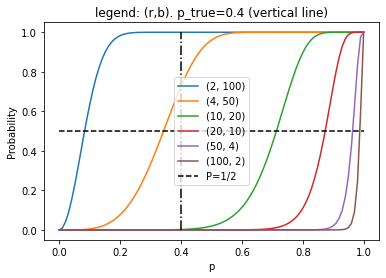

In [11]:
import matplotlib.pyplot as plt
n = 200
ops = [(2,100),(4,50),(10,20),(20,10),(50,4),(100,2)]
yval = lambda p,r,b: 1-(1-p**r)**b
pts = np.linspace(0,1,100)
yval(pts,.2,.2)
for op in ops:
    plt.plot(pts, yval(pts,op[0],op[1]), label=op)
plt.plot(pts,0*pts+0.5,'k--', label="P=1/2")
plt.plot([0.4,0.4],[0,1], 'k-.')
plt.legend()
plt.xlabel('p')
plt.ylabel('Probability')
plt.title("legend: (r,b). p_true=0.4 (vertical line)")
plt.show()

### Effects of changing n while adjusting b,r to keep P=1/2 argument constant

Now let's solve for the optimal values r,b. 

We suppose that we *fix* $n,r,b$. Given these, we determine at which approximate point $p$ is the crossover. We should find $p=p(b,r)$. Afterwards, we can then approximately solve for $r,b$ to be a desired $p$

We begin with for $P=1/2$.
$$1/2 = 1-(1-p^r)^b$$
$$ 1-p^r = 2^{-1/b}$$
$$p = (1-2^{-1/b})^{1/r} = (1-e^{-(1/b)\ln2})^{1/r} \approx (1/b)^{1/r}*\text{const}$$

Finally, if we fix $r$ and $p$, we can find the required bands to be about
$$ b \approx 1/p^r

Takeaways:

increasing r -> 
* moves the curve right.
* more the false negatives
* means lower chance to match
                
increasing b -> 
* moves the curve left.
* more false positives
* means higher chance to match
                
increasing n -> 
* the curve approaches a step function.
* fewer false anythings
* always good!

Now watch what happens as we pick the optimal r,b and then increase n.

We will try to keep p centered around $p=0.5$

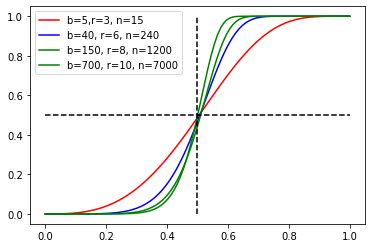

In [12]:
x = np.linspace(0,1,100)

b,r = 5, 3
y = 1-(1-x**r)**b
plt.plot(x,y,'r-',label=f"b={b},r={r}, n={b*r}")

b,r = 40, 6
y = 1-(1-x**r)**b
plt.plot(x,y,'b-',label=f"b={b}, r={r}, n={b*r}")

b,r = 150, 8
y = 1-(1-x**r)**b
plt.plot(x,y,'g-',label=f"b={b}, r={r}, n={b*r}")

b,r = 700, 10
y = 1-(1-x**r)**b
plt.plot(x,y,'g-',label=f"b={b}, r={r}, n={b*r}")


plt.plot(x,0*x+0.5,'k--')
plt.plot([0.5,0.5],[0,1],'k--')
plt.legend()
plt.show()

Now, we use all of the above to try to optimize our Localitly Sensitive Hash function from before.

Let's say we want a threshold of $p=0.3$. We can calculate $b\approx p^{-r}$ for the number of bands. 

For the first 6 values of band size we determine we should keep

$r=1 \to b=3,\,n=3$

$r=2 \to b=11,\,n=22$

$r=3 \to b=37,\,n=111$

$r=4 \to b=123,\,n=492$

$r=5 \to b=412,\,n=2060$

Let's try the intermediate choice, and use round numbers $n=120$, $b=40$, $r=3$

Let's see how good our results are using the previous defined functions. We first need to construct the banded similarity measure to be used on the signature matrix. Put this into a function

### Brute force banded candidate pair function, for checking hash method later

In [ ]:
def bandedCandidatePair(col1, col2, b, r):
    """Returns a boolean if the two columns are a candidate pair
    inputs must obey n=len(col1)=len(col2)=b*r"""
    n = len(col1)
    assert(n==b*r)
    assert(n==len(col2))
    truth_array = (col1==col2)
    return any(all(band) for band in np.array_split(truth_array,b))

def bandedCandidatePairs(sig_mat, b, r):
    d = sig_mat.shape[1]
    idxs = range(d)
    cols = [sig_mat[:,i] for i in range(d)]
    pairs = set()
    for (i,col1), (j,col2) in itertools.combinations(zip(idxs,cols),2):
        if bandedCandidatePair(col1,col2,b,r):
            pairs.add((i,j))
    return pairs

# set p = 0.3 arbitrarily
p = 0.3
n = 120
b = 30
r = 4

# see how many candidate pairs we got right!
sig_mat = hm(doc_shingles, n)
true_score_dict = trueSimScores(doc_shingles)
approx_score_dict = sigSimScores(sig_mat)
print("True pairs:",candidatePairs(true_score_dict, p))
print("LSH pairs:",bandedCandidatePairs(sig_mat, b, r))
print("Vanilla MinHash pairs:",candidatePairs(approx_score_dict, p))
# accMatrix(true_score_dict, approx_score_dict, 0.4)

# sig_mat = hm(doc_shingles, n)
# true_score_dict = trueSimScores(doc_shingles)
printScoreComparison(true_score_dict, approx_score_dict)

True pairs: {(0, 4), (1, 4)}
LSH pairs: {(0, 4), (1, 4)}
Vanilla MinHash pairs: {(0, 4), (3, 4), (1, 4)}
**~~~~~~ Similarity score comparison ~~~~~~**
Pair		Approx		True		%Error
(0, 1)		0.117		0.050		133.89
(0, 2)		0.142		0.069		105.69
(0, 3)		0.150		0.093		60.89
(0, 4)		0.475		0.336		41.28
(1, 2)		0.183		0.052		254.68
(1, 3)		0.175		0.051		240.45
(1, 4)		0.408		0.400		2.03
(2, 3)		0.233		0.081		188.18
(2, 4)		0.225		0.083		171.18
(3, 4)		0.325		0.294		10.36


### Finally, we perform the fast candidate pair search, using a hash table of band and column id's

Lastly, we will improve upon the whole efficiency by performing the comparisons of banded pairs in $\mathcal{O}(n)$ time as opposed to $\mathcal{O}(n^2)$

For each band of a column, we place a copy of the column index into a hash table, with key the row values.

For example, let col=[4,2,5,6]. This might band to say [(4,2),(5,6)], and we ould enter into a dictionary d={(4,2):[col,...], (5,6):[col,...], ...}

In [ ]:
def fastCandidatePairs(sig_mat, b, r):
    n, d = sig_mat.shape
    assert(n==b*r)
    hashbuckets = collections.defaultdict(set)
    bands = np.array_split(sig_mat, b, axis=0)
    for i,band in enumerate(bands):
        for j in range(d):
            # The last value must be made a string, to prevent accidental
            # key collisions of r+1 integers when we really only want
            # keys of r integers plus a band index
            band_id = tuple(list(band[:,j])+[str(i)])
            hashbuckets[band_id].add(j)
    candidate_pairs = set()
    for bucket in hashbuckets.values():
        if len(bucket) > 1:
            for pair in itertools.combinations(bucket, 2):
                candidate_pairs.add(pair)
    return candidate_pairs


# to make sure it works, 
# compare with the brute force method on a few trials

# set p = 0.3 arbitrarily
p = 0.3
n = 120
b = 30
r = 4

# see how many candidate pairs we got right!
sig_mat = hm(doc_shingles, n)
true_score_dict = trueSimScores(doc_shingles)
approx_score_dict = sigSimScores(sig_mat)
print('True pairs:\t', candidatePairs(true_score_dict, p))
print("True LSH pairs:\t", bandedCandidatePairs(sig_mat, b, r))
print("Fast LSH pairs:\t", fastCandidatePairs(sig_mat, b, r))
print("MinHash pairs:\t", candidatePairs(approx_score_dict, p))

True pairs:	 {(0, 4), (1, 4)}
True LSH pairs:	 {(2, 3), (3, 4), (1, 4)}
Fast LSH pairs:	 {(2, 3), (3, 4), (1, 4)}
MinHash pairs:	 {(0, 4), (3, 4), (1, 4)}


# Part II: vector similarity

In [ ]:
def cossim(u,v):
    norm = np.linalg.norm(u)*np.linalg.norm(v)
    cosine = u@v/norm
    ang = np.arccos(cosine)
    return 1-ang/np.pi

## Generate data

We create N random vectors of dimension D. We then reassign 5 of these to be artifically close to another set of 5. This is done by setting them equal and adding a small amount of noise.

By artificially making some vectors closer to others, we can easily tune the target similarity threshold, allowing us to experiment better.

In [ ]:
# get some random data points
N = 1000
D= 50
A = np.random.randn(N,D)
# artificially make some similar to others
A[5] = A[99] +np.random.randn(D)*0.05
A[20] = A[85] +np.random.randn(D)*0.15
A[13] = A[19] +np.random.randn(D)*0.25
A[56] = A[71] +np.random.randn(D)*0.5
A[45] = A[49] +np.random.randn(D)*0.66

## Brute force calculation baseline

This is straightforward. We compute the cosine similarity of every possible pair, and keep only those that are at or above the chosen threshold

We know beforehand that the smallest "artificially most similar" pair is going to be around ~0.82, so we set the threshold to be 0.8.

In practice, setting the threshold is an art, and depends on how similar we want things to really be.

In [ ]:
true_pairs_dict = {}

thresh = 0.8

start = time.time()
for (i,u),(j,v) in itertools.combinations([(i,x) for i,x in enumerate(A)],2):
    val = cossim(u,v)
    if val > thresh:
        true_pairs_dict[(i,j)] = val
t_brute = time.time()-start

# save just the keys without the values. Easier to compare later to LSH
true_pairs = set(true_pairs_dict.keys())

print(f"Brute force calculation time: {t_brute:.3f}")
print(f"Discovered pairs:")
for k, v in true_pairs_dict.items():
    print(f"Pair: {k},\tSimilarity: {v:.2f}.")

Brute force calculation time: 6.184
Discovered pairs:
Pair: (5, 99),	Similarity: 0.98.
Pair: (13, 19),	Similarity: 0.92.
Pair: (20, 85),	Similarity: 0.95.
Pair: (45, 49),	Similarity: 0.82.
Pair: (56, 71),	Similarity: 0.86.


## Locality Sensitive Hashing approach

### Find r, b parameters given threshold

We must have that D%b==0, that is the number of bands divides the dimension. That's our only constraint. Remember, higher n is always better!

There's no magic here, we just trial and error some combinations until we get near the desired threshold, in this case 0.75 (chosen in the previous cell)

In [ ]:
b, r = 50, 18

n = b*r
print(f"Transition probability: {(1/b)**(1/r):.2f}")

Transition probability: 0.80


### Compute LSH pairs

Let $S$ be the signature matrix and $R$ be the matrix of random hyperplanes.

In the code implementation, we work with the transpose of our equations. This means that $S = (N,D)$, and so we have to split into bands across axis=1

In [ ]:
start = time.time()

# Compute signature matrix
R = A@np.random.randn(D,n)
S = np.where(R>0,1,0)

# Break into bands
S = np.split(S, b, axis=1)

# column vector to convert binary vector to integer e.g. (1,0,1)->5
binary_column = 2**np.arange(r).reshape(-1,1)

# convert each band into a single integer, 
# i.e. convert band matrices to band columns
S = np.hstack([M@binary_column for M in S])

# Every value in the matrix represents a hash bucket assignment
# For every bucket in row i, add index i to that bucket
d = collections.defaultdict(set)
with np.nditer(S,flags=['multi_index']) as it:
    for x in it:
        d[int(x)].add(it.multi_index[0])
        
# For every bucket, find all pairs. These are the LSH pairs.
candidate_pairs = set()
for k,v in d.items():
    if len(v) > 1:
        for pair in itertools.combinations(v,2):
            candidate_pairs.add(tuple(sorted(pair)))

# Finally, perform the actually similarity computation
# to weed out false positive
lsh_pairs = set()
for (i,j) in candidate_pairs:
    if cossim(A[i],A[j]) > thresh:
        lsh_pairs.add((i,j))
        
t_lsh = time.time()-start

print(f"LSH calculation time: {t_lsh:.3f}")

LSH calculation time: 0.249


## Compare the two methods

The above should show that we get a factor of about 25x speedup, while simultaneously finding all pairs, with no false negatives!

Very useful!

In [ ]:
print(f"t_brute: {t_brute:.3f}\t t_lsh: {t_lsh:.3f}. Speed-up: {t_brute/t_lsh:.0f}x")
print("True pairs: ", pairs_true)
print("LSH pairs: ", lsh_pairs)
print(f"Candidate pairs: {len(candidate_pairs)}.\n\
False negatives: {len(pairs_true-lsh_pairs)}")

t_brute: 6.142	 t_lsh: 0.249. Speed-up: 25x
True pairs:  {(45, 49), (20, 85), (56, 71), (13, 19), (5, 99)}
LSH pairs:  {(45, 49), (20, 85), (56, 71), (13, 19), (5, 99)}
Candidate pairs: 4876.
False negatives: 0
